In [1]:
import os
import sys
sys.path.append('../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from libs.utils import filter_glucose_by_range, filter_noisy_data

In [2]:
data_root = "/mnt/data2/mtseng/dataset/SeNSE/TCH_processed/beat"
subject_id = 'c2s05'

In [3]:
df = pd.read_pickle(os.path.join(data_root, f"{subject_id}.pkl"))
print(df.head())
print(df.shape)

                                                Time  \
0  [2022-11-28T10:33:07.623000000, 2022-11-28T10:...   
1  [2022-11-28T10:33:08.443000000, 2022-11-28T10:...   
2  [2022-11-28T10:33:09.383000000, 2022-11-28T10:...   
3  [2022-11-28T10:33:10.323000000, 2022-11-28T10:...   
4  [2022-11-28T10:33:11.259000000, 2022-11-28T10:...   

                                         EcgWaveform  \
0  [3139, 3129, 3119, 3111, 3107, 3104, 3104, 310...   
1  [1705, 1703, 1700, 1698, 1696, 1694, 1692, 168...   
2  [1872, 1872, 1874, 1875, 1876, 1876, 1877, 187...   
3  [1936, 1937, 1939, 1941, 1944, 1945, 1946, 194...   
4  [1933, 1933, 1933, 1935, 1936, 1938, 1940, 194...   

                                                  HR  glucose  CGM_idx  \
0  [65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 6...    114.0  20671.0   
1  [65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 6...    114.0  20671.0   
2  [65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 6...    114.0  20671.0   
3  [60, 60, 60, 60, 60, 60, 60

### Filter the signal

#### Filter out the part that are not in the desired range of glucose value

* Hypoglycemic range: 40 ~ 70 (mg/dL)
* Normal range: 70 ~ 180 (mg/dL)

In [4]:
# only select those in proper range of glucose (40-180)
filtered_df = filter_glucose_by_range(df)

Glucose Level Filtering (remove beats with glucose value outside 40-180 mg/dl ):
 - Original count:  1231148
 - Filtered count:  1172693
 - Availability ratio: 0.953


#### Filter out the noisy data according to the HRConfidence and ECGNoise

For a clean signal, it must satisfies:
* HRConfidence >= 100
* ECGNoise < 0.001

In [5]:
clean_df = filter_noisy_data(filtered_df)

Filter out noisy data (HRConfidence < 100 or ECGNoise >= 0.001):
 - Original:  1172693
 - Filtered:  882460
 - Availability Ratio: 0.753


### Data Statistics

We define $G$ and $E$ as the set of glucose and ECG respectively.
1. Average glucose in HG
$$
    \text{Average glucose in HG} = \bar G_{HG} = \frac{1}{|G_{HG}|}\sum_{g_i \in G_{HG}} g_i \text{, where } G_{HG} = \{g\in G | g < 70\}
$$
2. Average glucose in EG
$$
    \text{Average glucose in EG} = \bar G_{EG} = \frac{1}{|G_{EG}|}\sum_{g_i \in G_{EG}} g_i \text{, where } G_{EG} = \{g\in G | g \geq 70\}
$$
3. Percentage of HG readings
$$
    \text{Percentage of HG} = \frac{\# hg}{\# hg + \# eg} = \frac{|G_{HG}|}{|G_{HG}|+|G_{EG}|}
$$
4. Percentage of nocturnal HG readings
$$
    \text{Percentage of nocturnal HG} = \frac{\# hg \text{ during nocturnal}}{\# hg} = \frac{|G_{HG_n}|}{|G_{HG}|}\text{, where } G_{HG_n} = \{g\in G_{HG} | 0\leq ts(g).hr <7 \} 
$$
5. Average heart rate 
6. Percentage of ECG beats that pass QC (quality check) 
$$
    \text{\% ECG beats that pass QC} = \frac{\# \text{clean ecg}}{\# \text{ecg}} = \frac{|E^{QC}|}{|E|}\text{, where } E^{QC} = \{e\in E | (HRC(e) \geq 100) \text{ and } (Noise(e)<0.001) \} 
$$
7. Percentage of hypo ECG beats that pass QC
$$
\text{\% hg ECG beats that pass QC} = \frac{\# \text{clean hypo ecg}}{\# \text{clean ecg}} = \frac{|E^{QC}_{HG}|}{|E^{QC}|}\text{, where } E^{QC}_{HG} = \{e\in E^{QC} | glucose(e) < 70 \} 
$$
8. Percentage of nocturnal ECG beats that pass QC
$$
\text{\% nocturnal ECG beats that pass QC} = \frac{\# \text{clean nocturnal ecg}}{\# \text{clean ecg}} = \frac{|E^{QC}_{n}|}{|E^{QC}|}\text{, where } E^{QC}_{n} = \{e\in E^{QC} | 0\leq ts(e).hr <7 \} 
$$

#### CGM-Level

In [6]:
hypo_threshold = 70
df_glucose = filtered_df.drop_duplicates(subset='Timestamp', keep='first')

In [7]:
# average glucose in hg
average_glucose_in_hg = df_glucose[df_glucose['glucose'] < hypo_threshold]['glucose'].mean()
print('Average glucose in hg: {:.2f}'.format(average_glucose_in_hg))
average_glucose_in_eg = df_glucose[df_glucose['glucose'] >= hypo_threshold]['glucose'].mean()
print('Average glucose in eg: {:.2f}'.format(average_glucose_in_eg))
num_glucose_in_hg = df_glucose[df_glucose['glucose'] < hypo_threshold].shape[0]
num_glucose_in_eg = df_glucose[df_glucose['glucose'] >= hypo_threshold].shape[0]
print('Percentage of HG readings: {:.4f}'.format(num_glucose_in_hg / (num_glucose_in_hg + num_glucose_in_eg)))

# Hypoglycemic readings at night (12-7am)
nocturnal_hg = df_glucose[(df_glucose['Timestamp'].dt.hour >= 0) & (df_glucose['Timestamp'].dt.hour < 7)]
num_nocturnal_glucose_in_hg = nocturnal_hg[nocturnal_hg['glucose'] < 70].shape[0]
print('Percentage of nocturnal HG readings {:.4f}'.format(num_nocturnal_glucose_in_hg / num_glucose_in_hg))


Average glucose in hg: 62.49
Average glucose in eg: 108.33
Percentage of HG readings: 0.0720
Percentage of nocturnal HG readings 0.3828


#### Beat-Level

In [8]:
# Percentage of CGM readings below 70 mg/dl
cgm_hypo = clean_df[clean_df['glucose'] < hypo_threshold]
cgm_normal = clean_df[clean_df['glucose'] >= hypo_threshold]

average_hypo_glucose = cgm_hypo['glucose'].mean()
average_normal_glucose = cgm_normal['glucose'].mean()
average_hr = clean_df['avg_HR'].mean()

# Hypoglycemic readings at night (12-7am)
night_cgm = df[(df['Timestamp'].dt.hour >= 0) & (df['Timestamp'].dt.hour < 7)]
night_clean_cgm = clean_df[(clean_df['Timestamp'].dt.hour >= 0) & (clean_df['Timestamp'].dt.hour < 7)]

print('Average HR: {:.2f}'.format(average_hr))
# print('Percentage of clean hypo CGM readings: {:.3f}'.format(len(cgm_hypo) / len(filtered_df)))
print('Percentage of ECG beats that pass QC: {:.4f}'.format(len(clean_df) / len(filtered_df)))
print('Percentage of hypo ECG beats that pass QC: {:.4f}'.format(len(cgm_hypo) / len(clean_df)))
print('Percentage of nocturnal ECG beats that pass QC: {:.4f}'.format(len(night_clean_cgm) / len(clean_df)))



Average HR: 70.95
Percentage of ECG beats that pass QC: 0.7525
Percentage of hypo ECG beats that pass QC: 0.0749
Percentage of nocturnal ECG beats that pass QC: 0.2969


### Glucose Distribution

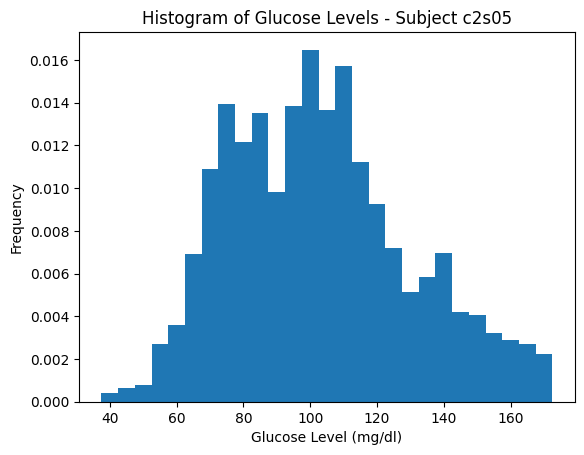

In [9]:
# generate the histogram of glucose levels
bins = np.arange(40, 180, 5)
hist, _ = np.histogram(clean_df['glucose'], bins=bins, density=True)

plt.bar(bins[:-1], hist, width=5)
plt.xlabel('Glucose Level (mg/dl)')
plt.ylabel('Frequency')
plt.title('Histogram of Glucose Levels - Subject {}'.format(subject_id))
plt.show()
